In [1]:
# Import python libraries
#
import importlib
import pickle
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Go one directory back, because all imports are done
# relative to the root of the project.
#
project_root = '..'
if 'change_directory_to_root' not in globals():
    change_directory_to_root = True
    os.chdir(project_root)

# Imports own modules.
#
import scripts.Visualization as Visualization
import scripts.ModelTrainer as ModelTrainer
import scripts.Utils as utils
import scripts.Simulation_config as Simulation_config
from scripts.Simulation_config import *
import scripts.Model as model
import scripts.ModelAdapter as ModelAdapter


/home/molu/miniconda3/envs/xlstm/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
No CUDA runtime is found, using CUDA_HOME='/home/molu/miniconda3/envs/xlstm'


In [2]:
importlib.reload(model)
importlib.reload(Simulation_config)
importlib.reload(utils)

# Print the sumarized simulation results
#
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')
result_dict


defaultdict(<function scripts.Utils.Evaluate_Models.print_results.<locals>.<lambda>()>,
            {'list': defaultdict(<function scripts.Utils.Evaluate_Models.print_results.<locals>.<lambda>.<locals>.<lambda>()>,
                         {0: defaultdict(<function scripts.Utils.Evaluate_Models.print_results.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                      {'SyntheticLoadProfile': [42.67864989666202,
                                        40.56075441794088,
                                        33.714984178215005,
                                        34.87803326633318,
                                        38.566710697276605,
                                        56.36118335221549,
                                        44.14006752839596,
                                        20.92187502263041,
                                        38.03530741054906,
                                        29.89331903471863,
                

In [32]:
# Store specific predictions, for the paper 'use case' section.
#
%script False

importlib.reload(model)
importlib.reload(utils)
importlib.reload(ModelTrainer)


# Define a specific configuration
#
myConfig = Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._37_HOUSEHOLDS, 
                NrOfComunities._20, TrainingHistory._15_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT)

modelTrainer = ModelTrainer.ModelTrainer()
loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
modelAdapter = ModelAdapter.ModelAdapter(public_holidays_timestamps, 
                                            train_size = myConfig.trainingHistory,
                                            test_size = modelTrainer.test_set_size_days, 
                                            prediction_history = myConfig.modelInputHistory,
                                            )
community_id = 0  # chose one of many energy communites
X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)
path_to_trained_parameters = 'scripts/outputs/all_trained_models_20241107_0520.pth'
num_of_features = X['train'].shape[2]
P_el_predicted = modelAdapter.deNormalizeY(Y['test']).flatten().unsqueeze(0)

# Store the predicted power profiles
#
for model_type in Simulation_config.UsedModels.ALL:
    test_profile = f"scripts/outputs/file_{community_id}.pkl"
    my_Model = utils.Deserialize.get_trained_model(path_to_trained_parameters, model_type, test_profile, myConfig, num_of_features)
    Y_pred = torch.Tensor(modelAdapter.deNormalizeY(my_Model.predict(X['test'], Y['test'])).flatten())
    P_el_predicted = torch.cat([P_el_predicted, Y_pred.unsqueeze(0)], dim=0)    

startdate = modelAdapter.getStartDateFromIndex('test', 0)
file_path = "scripts/outputs/example_predictions.pkl"
with open(file_path, 'wb') as file:
    pickle.dump((P_el_predicted, startdate), file)

print(P_el_predicted.shape)
print(startdate)


UsageError: Line magic function `%script` not found (But cell magic `%%script` exists, did you mean that instead?).


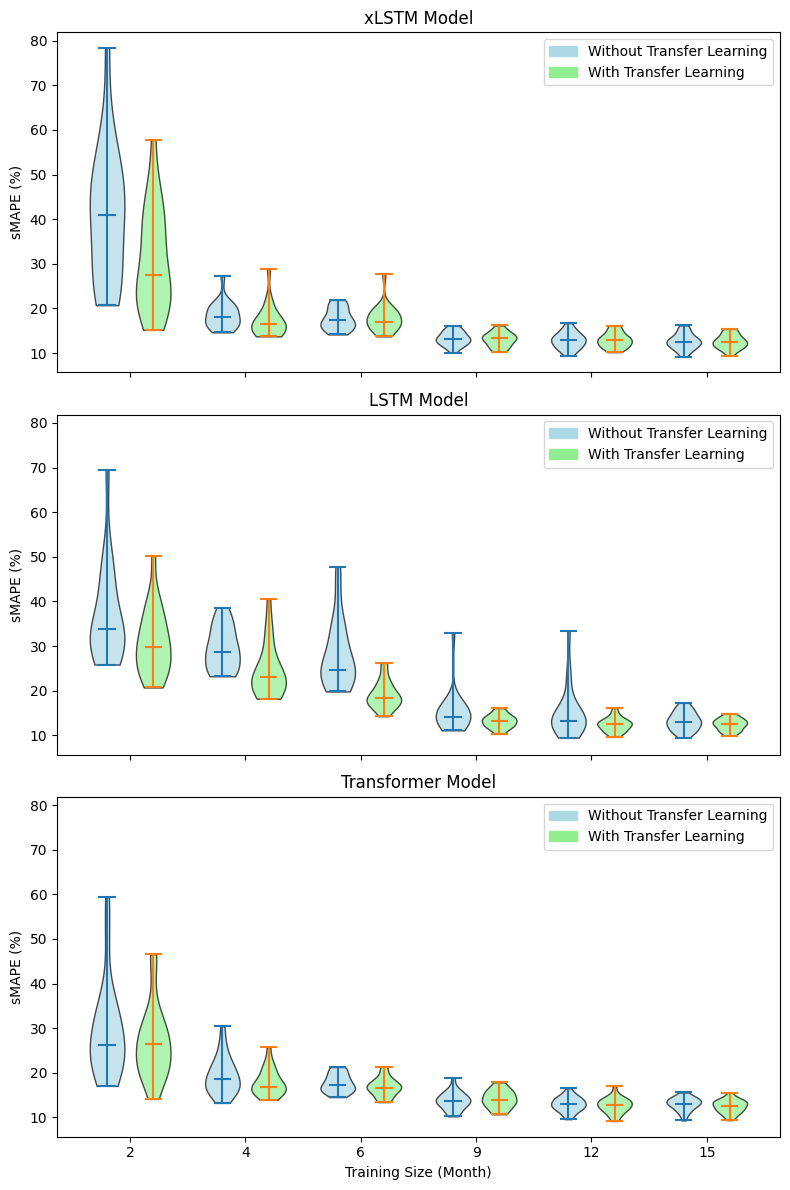

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.collections import PolyCollection

# Constants and Configuration
models = ['xLSTM', 'LSTM', 'Transformer']
training_sizes = ['2', '4', '6', '9', '12', '15']
configs_with_transfer = [*range(2, 7), 0]
configs_without_transfer = [*range(9, 14), 7]

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, configs, result_dict):
    return [result_dict['list'][config][model] for config in configs]

# Prepare data for each model and transfer condition
data_with_transfer = {model: get_full_data_list(model, configs_with_transfer, result_dict) for model in models}
data_without_transfer = {model: get_full_data_list(model, configs_without_transfer, result_dict) for model in models}

# Creating subplots for violin plots
fig, axes = plt.subplots(len(models), 1, figsize=(8, 12), sharex=True, sharey=True)

# Define legend patches for the legend
legend_patches = [
    Patch(color="lightblue", label="Without Transfer Learning"),
    Patch(color="lightgreen", label="With Transfer Learning")
]

# Plot each model's data on a separate subplot
for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Get data for each training size
    data_without = data_without_transfer[model]
    data_with = data_with_transfer[model]
    
    # Plot violin plots for without and with transfer data
    # Offset positions slightly for comparison
    positions = np.array(range(len(training_sizes))) * 2.0
    
    # Without Transfer Learning violins
    violins_without = ax.violinplot(data_without, positions=positions - 0.4, widths=0.6, 
                                    showmeans=False, showextrema=True, showmedians=True)
    # With Transfer Learning violins
    violins_with = ax.violinplot(data_with, positions=positions + 0.4, widths=0.6, 
                                 showmeans=False, showextrema=True, showmedians=True)

    # Set custom colors for the violins by modifying each PolyCollection
    for pc in violins_without['bodies']:
        pc.set_facecolor("lightblue")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
    for pc in violins_with['bodies']:
        pc.set_facecolor("lightgreen")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
    
    # Labels and title
    ax.set_ylabel('sMAPE (%)')
    ax.set_title(f"{model} Model")
    # ax.text(0.4, 0.9, f"{model} Model", transform=ax.transAxes, fontsize=16, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(training_sizes)
    
    # Set y-axis limits
    # ax.set_ylim(5, 80)
    
    # Add legend to each subplot
    ax.legend(handles=legend_patches, loc="upper right")
    
    # Set x-axis label for the last plot
    # ax.set_xlabel('Training Size (Month)')
    
axes[-1].set_xlabel('Training Size (Month)')
plt.savefig("scripts/outputs/transfer_learning_over_train_size.pdf", format="pdf")
plt.tight_layout()
plt.show()


In [ ]:
# 